[*********************100%***********************]  1 of 1 completed

Epoch 1/20



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1375
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0138
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0062
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0038
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0046
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0044
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0043
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0049
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0037
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0040
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0035
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0032
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0044
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0037
Epoch 15/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0029
Epoch 16/20
17/

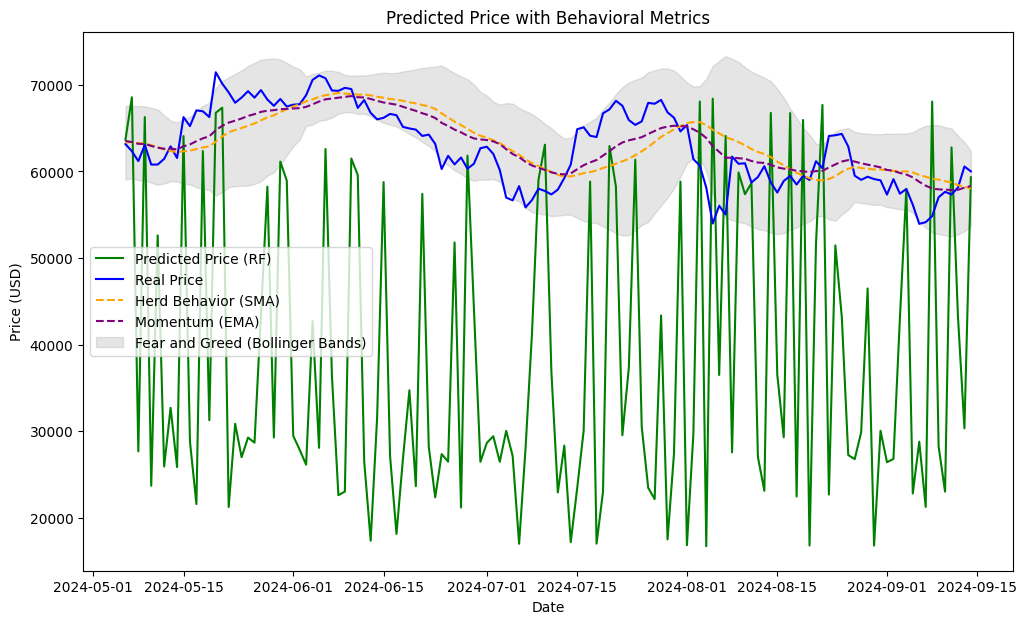

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import shap

# Step 1: Load Bitcoin Data (yfinance)
bitcoin_data = yf.download('BTC-USD', start='2022-09-07', end='2024-09-15')
bitcoin_data = bitcoin_data[['Close', 'Volume']].copy()

# Step 2: Preprocessing - Calculate Behavioral Metrics
bitcoin_data['SMA_20'] = bitcoin_data['Close'].rolling(window=20).mean()
bitcoin_data['EMA_20'] = bitcoin_data['Close'].ewm(span=20, adjust=False).mean()
bitcoin_data['Volatility'] = bitcoin_data['Close'].rolling(window=20).std()  # Volatility as a behavioral metric

# Bollinger Bands
bitcoin_data['Bollinger_Upper'] = bitcoin_data['SMA_20'] + (bitcoin_data['Volatility'] * 2)
bitcoin_data['Bollinger_Lower'] = bitcoin_data['SMA_20'] - (bitcoin_data['Volatility'] * 2)

# Drop NaN values from rolling calculations
bitcoin_data.dropna(inplace=True)

# Step 3: Normalize Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(bitcoin_data[['Close', 'Volume']])

# Step 4: Prepare LSTM Sequences for Feature Extraction
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0])  # Use the 'Close' price as the label
    return np.array(sequences), np.array(labels)

seq_length = 60  # Use 60 days of historical data to predict the future

X_lstm, y_lstm = create_sequences(scaled_data, seq_length)

# Step 5: Train LSTM Model for Feature Extraction
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='linear')  # Change the output layer to have 1 unit with linear activation
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Step 6: Extract LSTM Features
train_features = lstm_model.predict(X_train)
test_features = lstm_model.predict(X_test)

# Step 7: Train Random Forest Regressor on LSTM Features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_features, y_train)

# Step 8: Make Multi-step Predictions
predicted_prices_rf = rf_model.predict(test_features)

# Inverse scaling the predictions for visualization
predicted_prices_rf_unscaled = scaler.inverse_transform(np.concatenate((predicted_prices_rf.reshape(-1, 1), np.zeros((predicted_prices_rf.shape[0], 1))), axis=1))[:, 0]
real_prices_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

# Step 9: Visualization with Behavioral Metrics
plt.figure(figsize=(12, 7))
plt.plot(bitcoin_data.index[-len(predicted_prices_rf_unscaled):], predicted_prices_rf_unscaled, label='Predicted Price (RF)', color='green')
plt.plot(bitcoin_data.index[-len(predicted_prices_rf_unscaled):], bitcoin_data['Close'][-len(predicted_prices_rf_unscaled):], label='Real Price', color='blue')
plt.plot(bitcoin_data.index[-len(predicted_prices_rf_unscaled):], bitcoin_data['SMA_20'][-len(predicted_prices_rf_unscaled):], '--', label='Herd Behavior (SMA)', color='orange')
plt.plot(bitcoin_data.index[-len(predicted_prices_rf_unscaled):], bitcoin_data['EMA_20'][-len(predicted_prices_rf_unscaled):], '--', label='Momentum (EMA)', color='purple')
plt.fill_between(bitcoin_data.index[-len(predicted_prices_rf_unscaled):], bitcoin_data['Bollinger_Upper'][-len(predicted_prices_rf_unscaled):],
                 bitcoin_data['Bollinger_Lower'][-len(predicted_prices_rf_unscaled):], color='gray', alpha=0.2, label='Fear and Greed (Bollinger Bands)')
plt.title('Predicted Price with Behavioral Metrics')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


In [ ]:
import matplotlib.dates as mdates
import numpy as np
# Step 9: Visualize Each Anomaly in a Separate Plot
anomaly_indices = np.where(anomalies)[0]  # Get the indices of detected anomalies

for idx in anomaly_indices:
    # Define a range to plot around the anomaly for better context (e.g., 10 days before and after)
    start_idx = max(0, idx - 15)
    end_idx = min(len(bitcoin_data) - 1, idx + 15)
    anomaly_range = bitcoin_data.index[start_idx:end_idx + 1]

    plt.figure(figsize=(12, 7))

    # Plot the actual price and predicted price
    plt.plot(anomaly_range, bitcoin_data['Close'][start_idx:end_idx + 1], label='Actual Price', color='blue')
    plt.plot(anomaly_range, predicted_prices_lstm_inverse[start_idx:end_idx + 1], label='Predicted Price', color='green')

    # Highlight the detected anomaly point
    plt.scatter(bitcoin_data.index[idx], predicted_prices_lstm_inverse[idx], color='red', label='Anomaly', s=100)

    # Plot behavioral metrics for better understanding of the context
    plt.plot(anomaly_range, bitcoin_data['SMA_20'][start_idx:end_idx + 1], '--', label='Herd Behavior (SMA)', color='orange')
    plt.fill_between(anomaly_range, bitcoin_data['Bollinger_Upper'][start_idx:end_idx + 1],
                     bitcoin_data['Bollinger_Lower'][start_idx:end_idx + 1], color='gray', alpha=0.2, label='Volatility Range')

    # Add titles and labels for each anomaly plot
    plt.title(f'Anomaly at {bitcoin_data.index[idx]+10}')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Format x-axis for better readability
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right') # Rotate the x-axis labels after setting the formatter

    plt.show()


NameError: name 'anomalies' is not defined

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.7 MB/s eta 0:00:00
